In [98]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes, leaguedashteamstats
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id
from nba_api.stats.static.teams import find_team_name_by_id
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow, Rectangle
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns
import glob
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import gamma, exponpow, lognorm, cauchy, genhyperbolic
from datetime import date
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [103]:
def convert_season_to_int(season):
    season = season.split('-')[0]
    return int(season) + 1

def convert_int_to_season(year):
    previos_year = year - 1
    year = str(year)
    previous_year = str(previos_year)
    year = year[-2:]
    return f'{previos_year}-{year}'

color = {'ATL':'#CC092F',
        'BOS':'#008853',
        'BKN':'#000000',
        'CHA':'#1D8CAB',
        'CHI':'#BC032B',
        'CLE':'#860038',
        'DAL':'#1061AC',
        'DEN':'#FDB827',
        'DET':'#ED174C',
        'GSW':'#006BB6',
        'HOU':'#D31145',
        'IND':'#002D62',
        'LAC':'#D81D47',
        'LAL':'#FDB827',
        'MEM':'#23375B',
        'MIA':'#BF2F38',
        'MIL':'#00461B',
        'MIN':'#005183',
        'NOR':'#002A5C',
        'NYK':'#F48328',
        'OKC':'#1E3160',
        'ORL':'#0075BD',
        'PHI':'#003DA5',
        'PHX':'#27235C',
        'POR':'#E13A3E',
        'SAC':'#724C9F',
        'SAS':'#84888B',
        'TOR':'#BE0F34',
        'UTA':'#0C2340',
        'WAS':'#E51837',
        'CHH':'#1D8CAB',
        'SEA':'#00653A',
        'SDC':'#D81D47',
        'NJN':'#C6CFD4',
        'WA1':'#E51837',
        'VAN':'#23375B',
        'KCK':'#724C9F'}

In [40]:
season_year = '2023-24'

first_year = 1990
last_year = 2024

all_teams = pd.DataFrame()

for year in tqdm(range(first_year, last_year + 1)):
    season_year = convert_int_to_season(year)


    team_stats_advanced = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced',
                                                                  season_type_all_star='Regular Season',
                                                                  season=season_year, 
                                                                  league_id_nullable='00',                                                              
                                                                  ).get_data_frames()[0]

    time.sleep(0.5)

    team_stats_basic = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Base',
                                                                  season_type_all_star='Regular Season',
                                                                  season=season_year, 
                                                                  league_id_nullable='00',                                                              
                                                                  ).get_data_frames()[0]
    time.sleep(0.5)

    combined_team_stats = pd.merge(team_stats_basic, team_stats_advanced, on=['TEAM_ID', 'TEAM_NAME'])

    combined_team_stats['SEASON'] = season_year

    average_off_rating = np.mean(combined_team_stats.OFF_RATING)

    combined_team_stats['REL_OFF_RTG'] = np.round(((combined_team_stats.OFF_RATING / average_off_rating) - 1) * 100, 2)
    
    combined_team_stats['AVG_OFF_RTG'] = np.round(average_off_rating, 2)
    
    all_teams = pd.concat([all_teams, combined_team_stats])

100%|███████████████████████████████████████████| 35/35 [00:48<00:00,  1.39s/it]


In [43]:
all_teams

,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,...,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,SEASON,REL_OFF_RTG,AVG_OFF_RTG
0,82,56,26,0.683,3961.000000,2812,6307,0.446,659,1833,...,9,8,13,12,12,26,4,1996-97,1.32,105.01
1,82,15,67,0.183,3981.000000,3066,6967,0.440,467,1331,...,19,27,11,24,24,2,28,1996-97,-2.01,105.01
2,82,54,28,0.659,3960.833333,2988,6342,0.471,591,1382,...,16,20,5,3,2,22,10,1996-97,3.89,105.01
3,82,69,13,0.841,3945.833333,3277,6923,0.473,523,1403,...,10,2,2,5,7,17,2,1996-97,7.04,105.01
4,82,42,40,0.512,3971.000000,2704,5972,0.453,483,1284,...,5,16,14,15,18,29,13,1996-97,-2.20,105.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,15,9,6,0.600,730.000000,627,1350,0.464,222,631,...,2,20,13,13,15,13,22,2023-24,0.24,113.32
26,17,3,14,0.176,826.000000,709,1558,0.455,211,620,...,17,26,26,25,26,4,28,2023-24,-6.20,113.32
27,17,8,9,0.471,826.000000,715,1524,0.469,194,567,...,9,7,23,20,24,20,16,2023-24,-1.52,113.32
28,16,5,11,0.313,778.000000,663,1460,0.454,219,612,...,12,2,30,22,22,9,24,2023-24,-1.43,113.32


<Axes: xlabel='OFF_RATING', ylabel='DEF_RATING'>

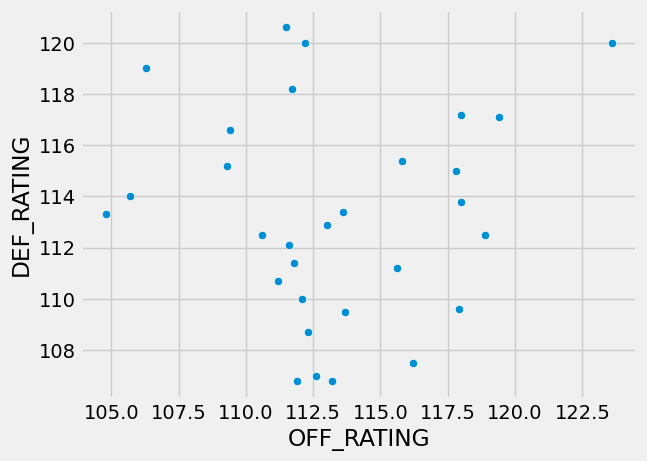

In [24]:
sns.scatterplot(data=combined_team_stats, x='OFF_RATING', y='DEF_RATING')

In [26]:
average_off_rating = np.mean(combined_team_stats.OFF_RATING)

print(average_off_rating)
for i in range(len(combined_team_stats)):
    team_stats = combined_team_stats.iloc[i]
    team_name, team_id = team_stats.TEAM_NAME, team_stats.TEAM_ID
    off_rtg = team_stats.OFF_RATING
    rel_off_rtg_team = team_stats.REL_OFF_RTG
    rel_off_rtg = (off_rtg / average_off_rating) - 1
    rel_off_rtg = np.round(rel_off_rtg * 100, 2)
    print(team_name, rel_off_rtg_team, rel_off_rtg, off_rtg)

113.32333333333332
Atlanta Hawks 5.36 5.36 119.4
Boston Celtics 2.54 2.54 116.2
Brooklyn Nets 2.19 2.19 115.8
Charlotte Hornets -0.99 -0.99 112.2
Chicago Bulls -3.55 -3.55 109.3
Cleveland Cavaliers -2.4 -2.4 110.6
Dallas Mavericks 4.13 4.13 118.0
Denver Nuggets 2.01 2.01 115.6
Detroit Pistons -3.46 -3.46 109.4
Golden State Warriors -0.29 -0.29 113.0
Houston Rockets -1.26 -1.26 111.9
Indiana Pacers 9.07 9.07 123.6
LA Clippers -0.9 -0.9 112.3
Los Angeles Lakers -1.87 -1.87 111.2
Memphis Grizzlies -6.73 -6.73 105.7
Miami Heat -1.08 -1.08 112.1
Milwaukee Bucks 3.95 3.95 117.8
Minnesota Timberwolves -0.11 -0.11 113.2
New Orleans Pelicans -1.34 -1.34 111.8
New York Knicks 0.33 0.33 113.7
Oklahoma City Thunder 4.04 4.04 117.9
Orlando Magic -0.64 -0.64 112.6
Philadelphia 76ers 4.92 4.92 118.9
Phoenix Suns 4.13 4.13 118.0
Portland Trail Blazers -7.52 -7.52 104.8
Sacramento Kings 0.24 0.24 113.6
San Antonio Spurs -6.2 -6.2 106.3
Toronto Raptors -1.52 -1.52 111.6
Utah Jazz -1.43 -1.43 111.7
Washi

In [181]:
top10_rel_off_rtg = all_teams.sort_values(by=['REL_OFF_RTG'], ascending=True)[['TEAM_NAME', 'TEAM_ID', 'OFF_RATING', 'AVG_OFF_RTG', 'REL_OFF_RTG', 'SEASON']].tail(10)

cleaned = all_teams.sort_values(by=['REL_OFF_RTG'], ascending=True)[['TEAM_NAME', 'TEAM_ID', 'OFF_RATING', 'AVG_OFF_RTG', 'REL_OFF_RTG', 'SEASON']]

cleaned[cleaned['TEAM_ID'] == 1610612747]

,TEAM_NAME,TEAM_ID,OFF_RATING,AVG_OFF_RTG,REL_OFF_RTG,SEASON
13,Los Angeles Lakers,1610612747,100.7,105.56,-4.60,2015-16
13,Los Angeles Lakers,1610612747,105.3,108.16,-2.64,2016-17
13,Los Angeles Lakers,1610612747,103.2,105.68,-2.35,2013-14
13,Los Angeles Lakers,1610612747,102.3,104.74,-2.33,2014-15
13,Los Angeles Lakers,1610612747,107.4,109.72,-2.11,2018-19
13,Los Angeles Lakers,1610612747,111.2,113.32,-1.87,2023-24
13,Los Angeles Lakers,1610612747,109.8,111.71,-1.71,2020-21
13,Los Angeles Lakers,1610612747,106.0,107.84,-1.71,2017-18
13,Los Angeles Lakers,1610612747,110.0,111.38,-1.24,2021-22
13,Los Angeles Lakers,1610612747,113.9,114.08,-0.15,2022-23


In [99]:
find_team_name_by_id(1610612737)

{'id': 1610612737,
 'full_name': 'Atlanta Hawks',
 'abbreviation': 'ATL',
 'nickname': 'Hawks',
 'city': 'Atlanta',
 'state': 'Georgia',
 'year_founded': 1949}

10. Dallas Mavericks 2001-02 +6.99%
9. Chicago Bulls 1996-97 +7.04%
8. Utah Jazz 1996-97 +7.04%
7. Sacramento Kings 2003-04 +7.11%
6. Phoenix Suns 2006-07 +7.24%
5. Utah Jazz 1997-98 +7.3%
4. Golden State Warriors 2015-16 +7.52%
3. Phoenix Suns 2004-05 +7.84%
2. Dallas Mavericks 2003-04 +8.88%
1. Indiana Pacers 2023-24 +9.07%


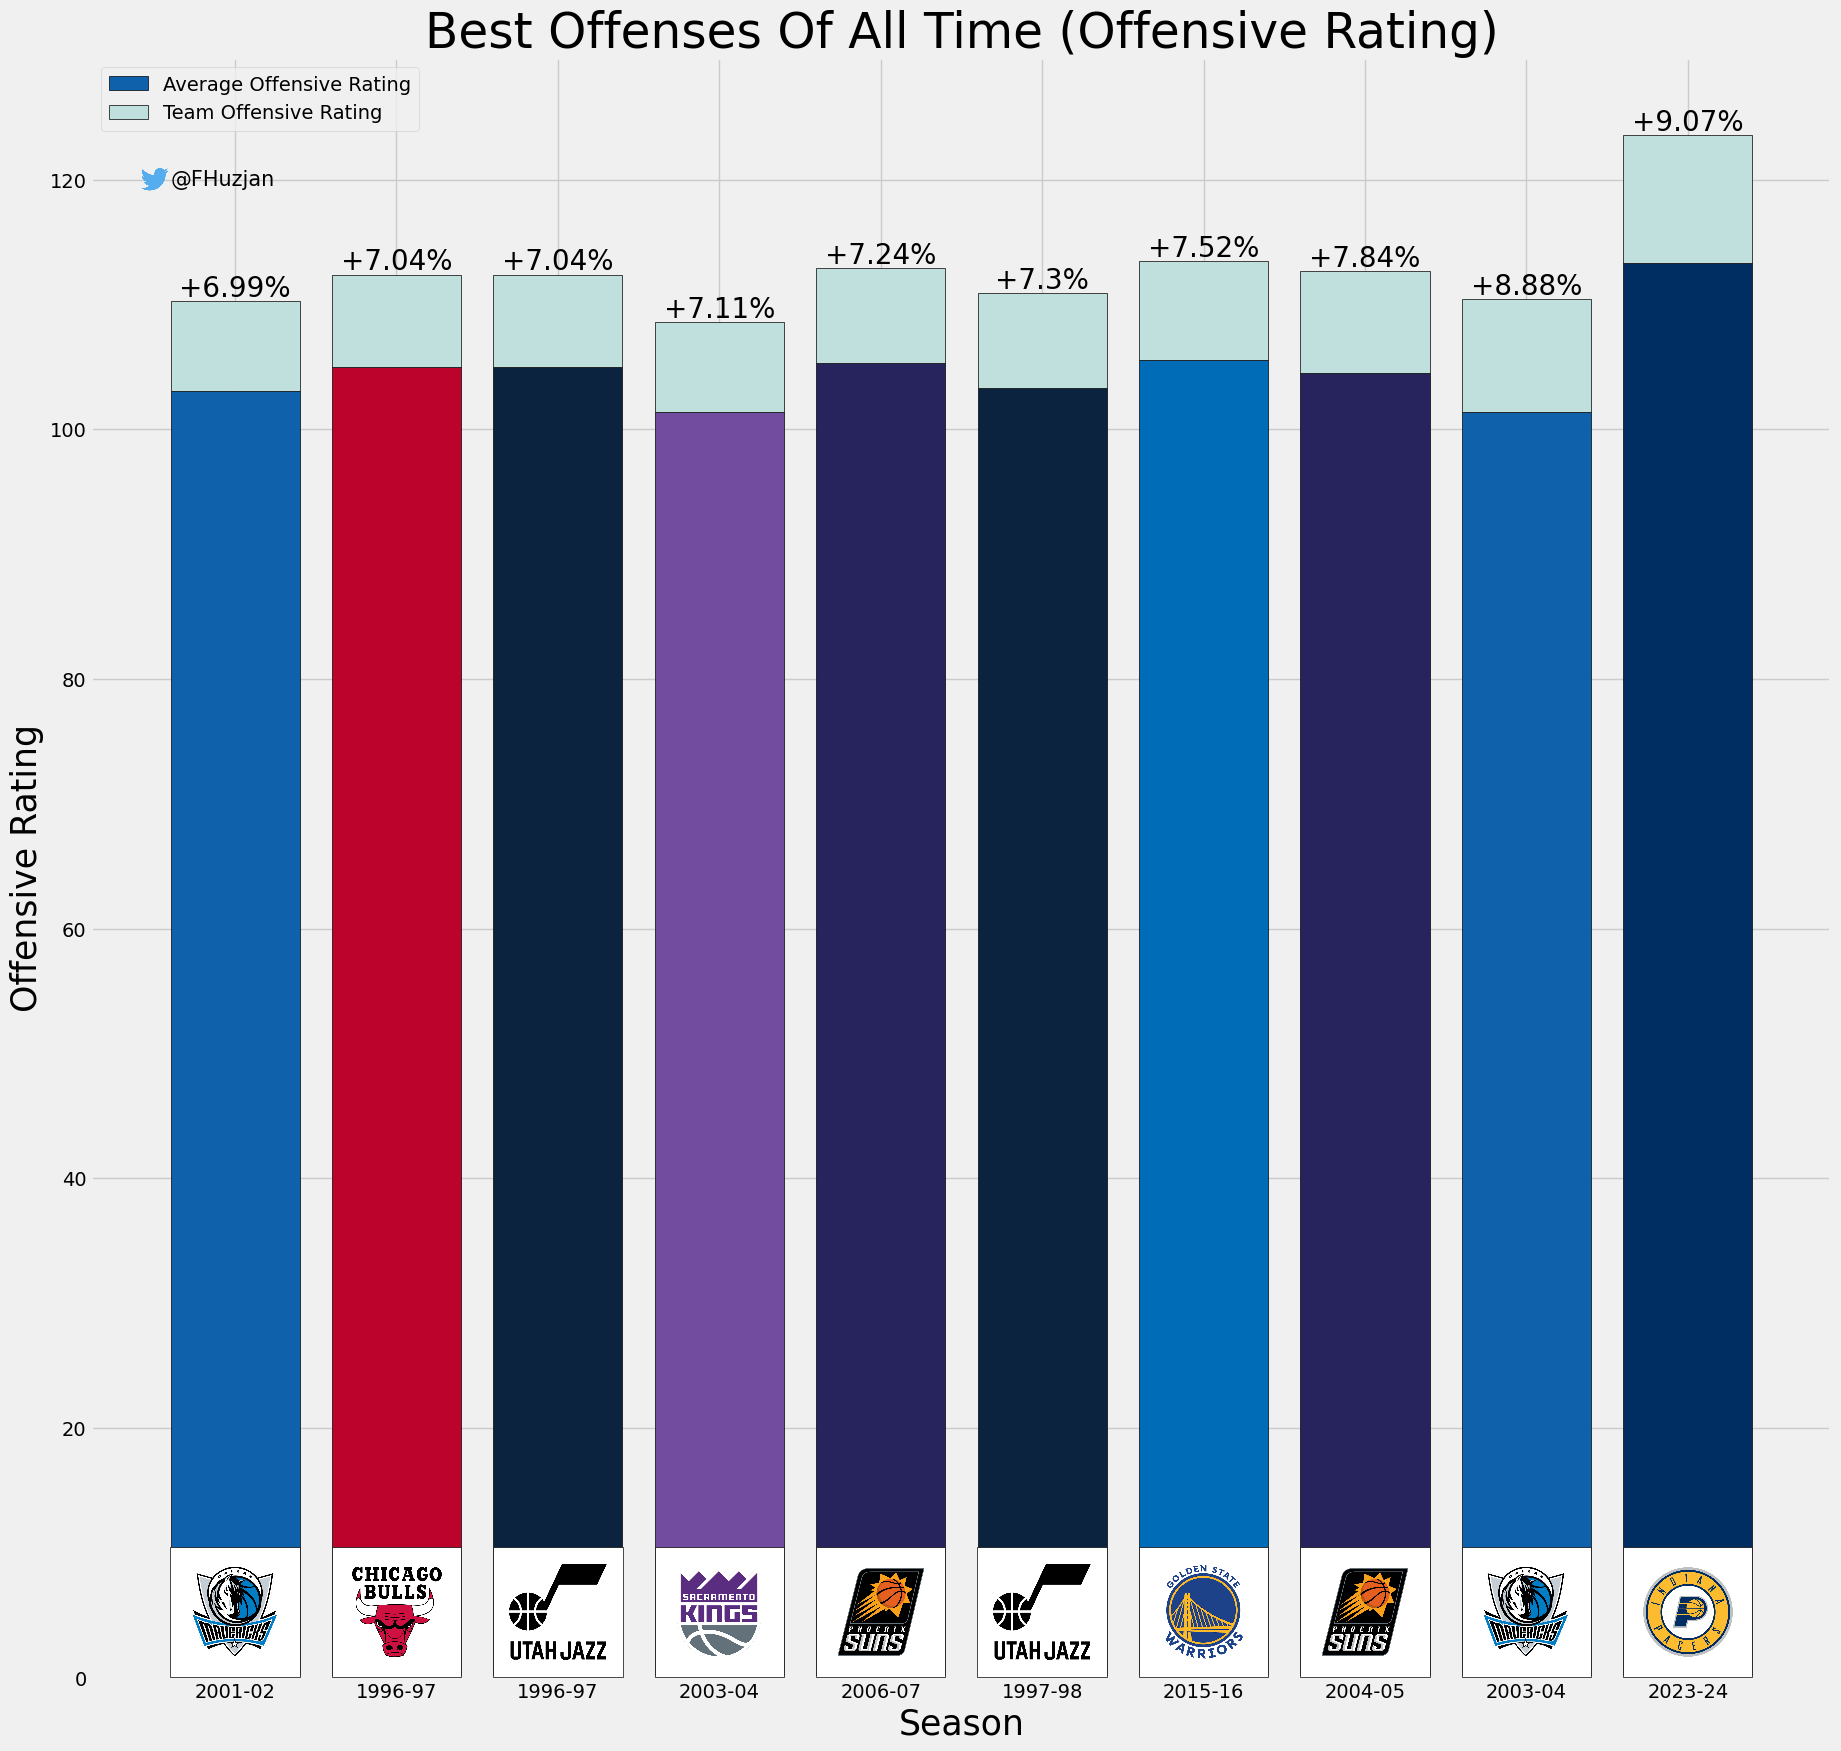

In [179]:
team_root_dir = 'team_imgs/'
zoom = 0.1025

def get_team_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{player_id}.png'), zoom=zoom)

wins_fgm_color = "#4F7CAC"
wins_fga_color = "#C0E0DE"

losses_fgm_color = "#99621E"
losses_fga_color = "#D38B5D"

edge_color = 'black'

width = 0.8

fig, ax = plt.subplots(figsize=(20, 20))

seasons = []
for i in range(len(top10_rel_off_rtg)):
    team = top10_rel_off_rtg.iloc[i]
    team_id = team.TEAM_ID
    season = team.SEASON
    
    seasons.append(season)
    off_rtg, avg_off_rtg, rel_off_rtg = team.OFF_RATING, team.AVG_OFF_RTG, team.REL_OFF_RTG
    team_color = color[find_team_name_by_id(team_id)['abbreviation']]
    if i == 0:
        plt.bar(i, avg_off_rtg, width=width, color=team_color, label='Average Offensive Rating', edgecolor=edge_color)
        plt.bar(i, off_rtg - avg_off_rtg, bottom=avg_off_rtg, width=width, color=wins_fga_color, label='Team Offensive Rating', edgecolor=edge_color)
    
    else:
        plt.bar(i, avg_off_rtg, width=width, color=team_color, edgecolor=edge_color)
        plt.bar(i, off_rtg - avg_off_rtg, bottom=avg_off_rtg, width=width, color=wins_fga_color, edgecolor=edge_color)
    
    ab_regular = AnnotationBbox(TextArea(f'+{rel_off_rtg}%', {'size': 20}), (i, off_rtg + 1), frameon=False)
    # ab_regular = AnnotationBbox(TextArea(f'+{np.round(off_rtg - avg_off_rtg, 2)}', {'size': 20}), (i, off_rtg + 1), frameon=False)

    ax.add_artist(ab_regular)
    
    ab_team = AnnotationBbox(get_team_img(team_id), (i, 5.25), frameon=True)
    ax.add_artist(ab_team)
    
    print(f'{10 - i}. {team.TEAM_NAME} {season} +{rel_off_rtg}%')

    
plt.legend(loc='upper left')
ax.set_xticklabels((seasons))
ax.set_xticks((range(len(seasons))))
ax.set_xlabel("Season", fontsize=25)
ax.set_ylabel("Offensive Rating", fontsize=25)
plt.title('Best Offenses Of All Time (Offensive Rating)', fontsize=35)
ab = AnnotationBbox(OffsetImage(plt.imread(f'twitter_logo (1).png'), zoom=0.1), (-0.5, 120), frameon=False)
ax.add_artist(ab)
ax.text(x=-0.4, y=119.5, ha='left', s='@FHuzjan', size=15)
plt.savefig('Graphs/best_off.png', bbox_inches='tight')